# Imports and Setup

In [1]:
from datetime import datetime
import functools
import jax
from IPython.display import HTML, display, clear_output
from jax import numpy as jp
import numpy as np
from typing import Any, Sequence, Tuple, Union, List

from brax import base
from brax import envs
from brax import math
from brax.base import Motion, Transform
from brax.envs.base import PipelineEnv, State
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import mjcf, model

from etils import epath
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from brax.training.acme import running_statistics
from brax.training.acme import specs
import os

import functools
import time
from typing import Callable, Optional, Tuple, Union

from absl import logging
from brax import base
from brax import envs
from brax.training import acting
from brax.training import gradients
from brax.training import pmap
from brax.training import types
from brax.training.acme import running_statistics
from brax.training.acme import specs
from brax.training.agents.ppo import losses as ppo_losses
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.types import Params
from brax.training.types import PRNGKey
from brax.v1 import envs as envs_v1
import flax
import jax
import numpy as np
import optax

from typing import Sequence, Tuple
from brax.training import types
from brax.training.types import PRNGKey
import flax
from flax import linen
from typing import Any, Callable, Sequence, Tuple
import dataclasses

# Networks Train

In [2]:
@dataclasses.dataclass
class FeedForwardNetwork:
  init: Callable[..., Any]
  apply: Callable[..., Any]

ActivationFn = Callable[[jp.ndarray], jp.ndarray]
Initializer = Callable[..., Any]

def small_random_normal(stddev=0.00001):
    """Custom initializer for biases with small random values centered around zero."""
    def init(key, shape, dtype=jp.float32):
        return jax.random.normal(key, shape, dtype=dtype) * stddev
    return init

def identity_like_init(scale=0.00001, c=5):
    """Custom initializer for near-identity matrices."""
    def init(key, shape, dtype=jp.float32,i=1, num=1):
        assert shape[0] == shape[1], "Identity-like init is designed for square matrices only"
        # Create a matrix that is mostly zeros
        matrix = jp.identity(shape[0], dtype=dtype) * c
        if i == 0:
          matrix = matrix * 1/(c**num)
        noise = jax.random.uniform(key, shape, dtype=dtype, minval=-scale, maxval=scale)
        return matrix + noise
    return init

class IMLP(linen.Module):
    layer_sizes: Sequence[int]
    activation: ActivationFn = linen.tanh
    kernel_init: Initializer = identity_like_init(scale=0.00001)
    bias_init: Initializer = small_random_normal(stddev=0.00001)
    bias: bool = True
    

    @linen.compact
    def __call__(self, data: jp.ndarray):
        hidden = data
        for i, hidden_size in enumerate(self.layer_sizes):
            assert hidden_size == data.shape[-1], "For identity init, all layers must match input size"
            hidden = linen.Dense(
                hidden_size,
                name=f'hidden_{i}',
                kernel_init=functools.partial(self.kernel_init,i=i, num=len(self.layer_sizes)),
                bias_init=self.bias_init,
                use_bias=self.bias)(
                    hidden)
            if i != len(self.layer_sizes) - 1:
                hidden = self.activation(hidden)
        return hidden

def make_random_network(
    obs_size: int,
    hidden_layer_sizes: Sequence[int] = (256, 256),
    activation: ActivationFn = linen.tanh,
    scale=0.00001) -> FeedForwardNetwork:
  """Creates a policy network."""

  policy_module = IMLP(layer_sizes=list(hidden_layer_sizes),activation=activation,kernel_init=identity_like_init(scale=scale),bias_init=small_random_normal(stddev=scale))

  def apply(rand_params, obs):
    return policy_module.apply(rand_params, obs)

  dummy_obs = jp.zeros((1, obs_size))
  return FeedForwardNetwork(
      init=lambda key: policy_module.init(key, dummy_obs), apply=apply)

class Encoder(linen.Module):
    layer_sizes: Sequence[int]  # Sizes of each hidden layer
    activation: Callable[[jp.ndarray], jp.ndarray] = linen.relu  # Default activation function
    activate_final: bool = False


    @linen.compact
    def __call__(self, data):
        for i,size in enumerate(self.layer_sizes):
            z = linen.Dense(size)(data)
            if i != len(self.layer_sizes) - 1 or self.activate_final:
              z = self.activation(z)
        return z

class Decoder(linen.Module):
    layer_sizes: Sequence[int]  # Sizes of each hidden layer, typically reverse of the encoder
    activation: Callable[[jp.ndarray], jp.ndarray] = linen.relu  # Default activation function

    @linen.compact
    def __call__(self, data):
        for i,size in enumerate(self.layer_sizes):
            z = linen.Dense(size)(data)
            if i != len(self.layer_sizes) - 1 or self.activate_final:
              z = self.activation(z)
            z = self.activation(z)
        return z
    
def make_encode_decode(
    data_size_encode: int,
    data_size_decode: int,
    squash_size: int,
    hidden_layer_sizes_encode: Sequence[int] = (256, 256),
    hidden_layer_sizes_decode: Sequence[int] = (256, 256),
    activation: ActivationFn = linen.tanh,
    ) -> Union[FeedForwardNetwork,FeedForwardNetwork]:

  policy_module_encode = Encoder(layer_sizes=list(jp.concat((jp.array(hidden_layer_sizes_encode),jp.array([squash_size])))),activation=activation)
  policy_module_decode = Encoder(layer_sizes=list(jp.concat((jp.array(hidden_layer_sizes_decode),jp.array([data_size_decode])))),activation=activation)


  def apply_encode(params, data):
    return policy_module_encode.apply(params, data)
  
  def apply_decode(params, data):
    return policy_module_decode.apply(params, data)

  dummy_en = jp.zeros((1, data_size_encode))
  dummy_de = jp.zeros((1, squash_size))

  encode = FeedForwardNetwork(
      init=lambda key: policy_module_encode.init(key, dummy_en), apply=apply_encode)
  
  decode = FeedForwardNetwork(
      init=lambda key: policy_module_decode.init(key, dummy_de), apply=apply_decode)
  
  return (encode,decode)


In [3]:
def flatten_auto_encoder(p1,p2):
    total_con = []

    for layer in p1:
        hidden1 = p1[layer]

        k1 = hidden1['kernel']
        b1 = hidden1['bias']

        if len(k1.shape) == 4:

            flattened1 = k1.reshape(k1.shape[0], k1.shape[1], k1.shape[2]*k1.shape[3])

            con1 = jp.concatenate([flattened1, b1], axis=2)

            if len(total_con) == 0:
                total_con = con1
            else:
                total_con = jp.concatenate([total_con,con1],axis=2)
        
        else:
            flattened1 = k1.reshape(k1.shape[0]*k1.shape[0])

            con1 = jp.concatenate([flattened1, b1])

            if len(total_con) == 0:
                total_con = con1
            else:
                total_con = jp.concatenate([total_con,con1])

    for layer in p2:
        hidden2 = p2[layer]

        k2 = hidden2['kernel']
        b2 = hidden2['bias']

        if len(k2.shape) == 4:

            flattened2 = k2.reshape(k2.shape[0], k2.shape[1], k2.shape[2]*k2.shape[3])

            con2 = jp.concatenate([flattened2, b2], axis=2)

            total_con = jp.concatenate([total_con,con2],axis=2)

        else:
            
            flattened2 = k2.reshape(k2.shape[0]*k2.shape[0])

            con2 = jp.concatenate([flattened2, b2])

            total_con = jp.concatenate([total_con,con2])

    return total_con

In [4]:
def inverse_flatten_single(flat,p1_size,p2_size,p1_len,p2_len):
    
    offset = 0

    p1 = {}
    p2 = {}

    for i in range(p1_len):
        p1[f'hidden_{i}'] = {}
        p1[f'hidden_{i}']['kernel'] = flat[offset:p1_size*p1_size+offset].reshape(p1_size,p1_size)
        offset += p1_size*p1_size
        p1[f'hidden_{i}']['bias'] = flat[offset:p1_size+offset]
        offset += p1_size

    for i in range(p2_len):
        p2[f'hidden_{i}'] = {}
        p2[f'hidden_{i}']['kernel'] = flat[offset:p2_size*p2_size+offset].reshape(p2_size,p2_size)
        offset += p2_size*p2_size
        p2[f'hidden_{i}']['bias'] = flat[offset:p2_size+offset]
        offset += p2_size

    return p1,p2


    

In [5]:
def auto_encoder_loss(params,data, en_obs, en_net, de_obs, de_net):
    obs_encoder =  params.obs_encoder
    obs_decoder =  params.obs_decoder
    net_encoder = params.net_encoder
    net_decoder = params.net_decoder

    p1 = data[5]['state_extras']['p1']['params']
    p2 = data[5]['state_extras']['p2']['params']

    obs = data[0]
    net = flatten_auto_encoder(p1,p2)

    # Encode the inputs using both encoders
    encoded_obs = en_obs.apply(obs_encoder, obs)
    encoded_net = en_net.apply(net_encoder, net)
    
    # Decode the encoded representations
    reconstructed_obs = de_obs.apply(obs_decoder, encoded_obs)
    reconstructed_net = de_net.apply(net_decoder, encoded_net)
    
    # Reconstruction loss (mean squared error)
    recon_loss1 = jp.mean((reconstructed_obs - obs) ** 2)
    recon_loss2 = jp.mean((reconstructed_net - net) ** 2)
    
    # Similarity loss (mean squared error between embeddings)
    similarity_loss = jp.mean((encoded_obs - encoded_net) ** 2)
    
    # Total loss is a weighted sum of reconstruction loss and similarity loss
    total_loss = recon_loss1 + recon_loss2 + similarity_loss
    return total_loss

## Train function

In [6]:
InferenceParams = Tuple[running_statistics.NestedMeanStd, Params]
Metrics = types.Metrics

_PMAP_AXIS_NAME = 'i'

@flax.struct.dataclass
class AutoEncoderParams:
  """Contains training state for the learner."""
  obs_encoder: Params
  net_encoder: Params
  obs_decoder: Params
  net_decoder: Params

@flax.struct.dataclass
class TrainingState:
  """Contains training state for the learner."""
  optimizer_state: optax.OptState
  auto_optimizer_state: optax.OptState
  params: ppo_losses.PPONetworkParams
  auto_params: AutoEncoderParams
  normalizer_params: running_statistics.RunningStatisticsState
  env_steps: jp.ndarray




def _unpmap(v):
  return jax.tree_util.tree_map(lambda x: x[0], v)


def _strip_weak_type(tree):
  # brax user code is sometimes ambiguous about weak_type.  in order to
  # avoid extra jit recompilations we strip all weak types from user input
  def f(leaf):
    leaf = jp.asarray(leaf)
    return leaf.astype(leaf.dtype)
  return jax.tree_util.tree_map(f, tree)


def train(
    environment: Union[envs_v1.Env, envs.Env],
    num_timesteps: int,
    episode_length: int,
    action_repeat: int = 1,
    num_envs: int = 1,
    max_devices_per_host: Optional[int] = None,
    num_eval_envs: int = 128,
    learning_rate: float = 1e-4,
    entropy_cost: float = 1e-4,
    discounting: float = 0.9,
    seed: int = 0,
    unroll_length: int = 10,
    batch_size: int = 32,
    num_minibatches: int = 16,
    num_updates_per_batch: int = 2,
    num_evals: int = 1,
    num_resets_per_eval: int = 0,
    normalize_observations: bool = False,
    reward_scaling: float = 1.0,
    clipping_epsilon: float = 0.3,
    gae_lambda: float = 0.95,
    deterministic_eval: bool = False,
    network_factory: types.NetworkFactory[
        ppo_networks.PPONetworks
    ] = ppo_networks.make_ppo_networks,
    auto_encoder_learning_rate = 1e-4,
    auto_encode_factory = make_encode_decode,
    progress_fn: Callable[[int, Metrics], None] = lambda *args: None,
    normalize_advantage: bool = True,
    eval_env: Optional[envs.Env] = None,
    policy_params_fn: Callable[..., None] = lambda *args: None,
    randomization_fn: Optional[
        Callable[[base.System, jp.ndarray], Tuple[base.System, base.System]]
    ] = None,
):
  """PPO training.

  Args:
    environment: the environment to train
    num_timesteps: the total number of environment steps to use during training
    episode_length: the length of an environment episode
    action_repeat: the number of timesteps to repeat an action
    num_envs: the number of parallel environments to use for rollouts
      NOTE: `num_envs` must be divisible by the total number of chips since each
        chip gets `num_envs // total_number_of_chips` environments to roll out
      NOTE: `batch_size * num_minibatches` must be divisible by `num_envs` since
        data generated by `num_envs` parallel envs gets used for gradient
        updates over `num_minibatches` of data, where each minibatch has a
        leading dimension of `batch_size`
    max_devices_per_host: maximum number of chips to use per host process
    num_eval_envs: the number of envs to use for evluation. Each env will run 1
      episode, and all envs run in parallel during eval.
    learning_rate: learning rate for ppo loss
    entropy_cost: entropy reward for ppo loss, higher values increase entropy
      of the policy
    discounting: discounting rate
    seed: random seed
    unroll_length: the number of timesteps to unroll in each environment. The
      PPO loss is computed over `unroll_length` timesteps
    batch_size: the batch size for each minibatch SGD step
    num_minibatches: the number of times to run the SGD step, each with a
      different minibatch with leading dimension of `batch_size`
    num_updates_per_batch: the number of times to run the gradient update over
      all minibatches before doing a new environment rollout
    num_evals: the number of evals to run during the entire training run.
      Increasing the number of evals increases total training time
    num_resets_per_eval: the number of environment resets to run between each
      eval. The environment resets occur on the host
    normalize_observations: whether to normalize observations
    reward_scaling: float scaling for reward
    clipping_epsilon: clipping epsilon for PPO loss
    gae_lambda: General advantage estimation lambda
    deterministic_eval: whether to run the eval with a deterministic policy
    network_factory: function that generates networks for policy and value
      functions
    progress_fn: a user-defined callback function for reporting/plotting metrics
    normalize_advantage: whether to normalize advantage estimate
    eval_env: an optional environment for eval only, defaults to `environment`
    policy_params_fn: a user-defined callback function that can be used for
      saving policy checkpoints
    randomization_fn: a user-defined callback function that generates randomized
      environments

  Returns:
    Tuple of (make_policy function, network params, metrics)
  """
  assert batch_size * num_minibatches % num_envs == 0
  xt = time.time()

  process_count = jax.process_count()
  process_id = jax.process_index()
  local_device_count = jax.local_device_count()
  local_devices_to_use = local_device_count
  if max_devices_per_host:
    local_devices_to_use = min(local_devices_to_use, max_devices_per_host)
  logging.info(
      'Device count: %d, process count: %d (id %d), local device count: %d, '
      'devices to be used count: %d', jax.device_count(), process_count,
      process_id, local_device_count, local_devices_to_use)
  device_count = local_devices_to_use * process_count

  # The number of environment steps executed for every training step.
  env_step_per_training_step = (
      batch_size * unroll_length * num_minibatches * action_repeat)
  num_evals_after_init = max(num_evals - 1, 1)
  # The number of training_step calls per training_epoch call.
  # equals to ceil(num_timesteps / (num_evals * env_step_per_training_step *
  #                                 num_resets_per_eval))
  num_training_steps_per_epoch = np.ceil(
      num_timesteps
      / (
          num_evals_after_init
          * env_step_per_training_step
          * max(num_resets_per_eval, 1)
      )
  ).astype(int)

  key = jax.random.PRNGKey(seed)
  global_key, local_key = jax.random.split(key)
  del key
  local_key = jax.random.fold_in(local_key, process_id)
  local_key, key_env, eval_key = jax.random.split(local_key, 3)
  # key_networks should be global, so that networks are initialized the same
  # way for different processes.
  key_policy, key_value, key1, key2, key3, key4 = jax.random.split(global_key, 6)
  del global_key

  assert num_envs % device_count == 0

  v_randomization_fn = None
  if randomization_fn is not None:
    randomization_batch_size = num_envs // local_device_count
    # all devices gets the same randomization rng
    randomization_rng = jax.random.split(key_env, randomization_batch_size)
    v_randomization_fn = functools.partial(
        randomization_fn, rng=randomization_rng
    )

  if isinstance(environment, envs.Env):
    wrap_for_training = envs.training.wrap
  else:
    wrap_for_training = envs_v1.wrappers.wrap_for_training

  env = wrap_for_training(
      environment,
      episode_length=episode_length,
      action_repeat=action_repeat,
      randomization_fn=v_randomization_fn,
  )

  reset_fn = jax.jit(jax.vmap(env.reset))
  key_envs = jax.random.split(key_env, num_envs // process_count)
  key_envs = jp.reshape(key_envs,
                         (local_devices_to_use, -1) + key_envs.shape[1:])
  env_state = reset_fn(key_envs)

  normalize = lambda x, y: x
  if normalize_observations:
    normalize = running_statistics.normalize
  ppo_network = network_factory(
      env_state.obs.shape[-1],
      env.action_size,
      preprocess_observations_fn=normalize)
  make_policy = ppo_networks.make_inference_fn(ppo_network)

  if env_state.info['p1'] != 0:
    pcount = flatten_auto_encoder(env_state.info['p1']['params'],env_state.info['p2']['params']).shape[-1]
    obs_encoder, obs_decoder = auto_encode_factory(
      data_size_encode = env_state.obs.shape[-1],
      data_size_decode = env_state.obs.shape[-1])

    net_encoder, net_decoder = auto_encode_factory(
    data_size_encode = pcount,
    data_size_decode =pcount)
  else:
    pcount = 1
    obs_encoder, obs_decoder = auto_encode_factory(
      data_size_encode = 1,
      data_size_decode = 1)

    net_encoder, net_decoder = auto_encode_factory(
    data_size_encode = pcount,
    data_size_decode =pcount)
  

  auto_optimizer = optax.adam(learning_rate=auto_encoder_learning_rate)

  auto_encode_loss_fn = functools.partial(
    auto_encoder_loss,
    en_obs=obs_encoder,
    en_net=net_encoder,
    de_obs=obs_decoder,
    de_net=net_decoder)
  
  auto_gradient_update_fn = gradients.gradient_update_fn(auto_encode_loss_fn, auto_optimizer, pmap_axis_name=_PMAP_AXIS_NAME, has_aux=False)

  optimizer = optax.adam(learning_rate=learning_rate)

  loss_fn = functools.partial(
      ppo_losses.compute_ppo_loss,
      ppo_network=ppo_network,
      entropy_cost=entropy_cost,
      discounting=discounting,
      reward_scaling=reward_scaling,
      gae_lambda=gae_lambda,
      clipping_epsilon=clipping_epsilon,
      normalize_advantage=normalize_advantage)

  gradient_update_fn = gradients.gradient_update_fn(loss_fn, optimizer, pmap_axis_name=_PMAP_AXIS_NAME, has_aux=True)

  def minibatch_step(carry, data: types.Transition, normalizer_params: running_statistics.RunningStatisticsState):
    optimizer_state, params, auto_opt, auto_params, key = carry
    key, key_loss= jax.random.split(key)
    (_, metrics), params, optimizer_state = gradient_update_fn(
        params,
        normalizer_params,
        data,
        key_loss,
        optimizer_state=optimizer_state)
    
    if pcount > 1:
      auto_loss, auto_params, auto_opt = auto_gradient_update_fn(
          auto_params,
          data,
          optimizer_state=auto_opt)

    return (optimizer_state, params, auto_opt, auto_params, key), metrics

  def sgd_step(carry, unused_t, data: types.Transition,  normalizer_params: running_statistics.RunningStatisticsState):
    optimizer_state, params, auto_opt, auto_params, key = carry
    key, key_perm, key_grad = jax.random.split(key, 3)

    def convert_data(x: jp.ndarray):
      x = jax.random.permutation(key_perm, x)
      x = jp.reshape(x, (num_minibatches, -1) + x.shape[1:])
      return x

    shuffled_data = jax.tree_util.tree_map(convert_data, data)
    (optimizer_state, params, auto_opt, auto_params, _), metrics = jax.lax.scan(
        functools.partial(minibatch_step, normalizer_params=normalizer_params),
        (optimizer_state, params, auto_opt, auto_params, key_grad),
        shuffled_data,
        length=num_minibatches)
    return (optimizer_state, params, auto_opt, auto_params, key), metrics

  def training_step(
      carry: Tuple[TrainingState, envs.State, PRNGKey],
      unused_t) -> Tuple[Tuple[TrainingState, envs.State, PRNGKey], Metrics]:
    training_state, state, key = carry
    key_sgd, key_generate_unroll, new_key = jax.random.split(key, 3)

    policy = make_policy(
        (training_state.normalizer_params, training_state.params.policy))

    def f(carry, unused_t):
      current_state, current_key = carry
      current_key, next_key = jax.random.split(current_key)
      next_state, data = acting.generate_unroll(
          env,
          current_state,
          policy,
          current_key,
          unroll_length,
          extra_fields=('truncation','p1','p2',))
      return (next_state, next_key), data

    (state, _), data = jax.lax.scan(
        f, (state, key_generate_unroll), (),
        length=batch_size * num_minibatches // num_envs)
    # Have leading dimensions (batch_size * num_minibatches, unroll_length)
    data = jax.tree_util.tree_map(lambda x: jp.swapaxes(x, 1, 2), data)
    data = jax.tree_util.tree_map(lambda x: jp.reshape(x, (-1,) + x.shape[2:]),
                                  data)
    assert data.discount.shape[1:] == (unroll_length,)

    # Update normalization params and normalize observations.
    normalizer_params = running_statistics.update(
        training_state.normalizer_params,
        data.observation,
        pmap_axis_name=_PMAP_AXIS_NAME)

    (optimizer_state, params, auto_optimizer_state, auto_params, _), metrics = jax.lax.scan(
        functools.partial(
            sgd_step, data=data, normalizer_params=normalizer_params),
        (training_state.optimizer_state, training_state.params, training_state.auto_optimizer_state,training_state.auto_params, key_sgd), (),
        length=num_updates_per_batch)

    new_training_state = TrainingState(
        optimizer_state=optimizer_state,
        auto_optimizer_state=auto_optimizer_state, 
        auto_params = auto_params,
        params=params,
        normalizer_params=normalizer_params,
        env_steps=training_state.env_steps + env_step_per_training_step)
    return (new_training_state, state, new_key), metrics

  def training_epoch(training_state: TrainingState, state: envs.State,
                     key: PRNGKey) -> Tuple[TrainingState, envs.State, Metrics]:
    (training_state, state, _), loss_metrics = jax.lax.scan(
        training_step, (training_state, state, key), (),
        length=num_training_steps_per_epoch)
    loss_metrics = jax.tree_util.tree_map(jp.mean, loss_metrics)
    return training_state, state, loss_metrics

  training_epoch = jax.pmap(training_epoch, axis_name=_PMAP_AXIS_NAME)

  # Note that this is NOT a pure jittable method.
  def training_epoch_with_timing(
      training_state: TrainingState, env_state: envs.State,
      key: PRNGKey) -> Tuple[TrainingState, envs.State, Metrics]:
    nonlocal training_walltime
    t = time.time()
    training_state, env_state = _strip_weak_type((training_state, env_state))
    result = training_epoch(training_state, env_state, key)
    training_state, env_state, metrics = _strip_weak_type(result)

    metrics = jax.tree_util.tree_map(jp.mean, metrics)
    jax.tree_util.tree_map(lambda x: x.block_until_ready(), metrics)

    epoch_training_time = time.time() - t
    training_walltime += epoch_training_time
    sps = (num_training_steps_per_epoch *
           env_step_per_training_step *
           max(num_resets_per_eval, 1)) / epoch_training_time
    metrics = {
        'training/sps': sps,
        'training/walltime': training_walltime,
        **{f'training/{name}': value for name, value in metrics.items()}
    }
    return training_state, env_state, metrics  # pytype: disable=bad-return-type  # py311-upgrade

  init_params = ppo_losses.PPONetworkParams(
      policy=ppo_network.policy_network.init(key_policy),
      value=ppo_network.value_network.init(key_value))
  init_auto_params = AutoEncoderParams(
      obs_encoder = obs_encoder.init(key1),
      net_encoder = net_encoder.init(key2),
      obs_decoder = obs_decoder.init(key3),
      net_decoder = net_decoder.init(key4)
  )
  training_state = TrainingState(  # pytype: disable=wrong-arg-types  # jax-ndarray
      optimizer_state=optimizer.init(init_params),  # pytype: disable=wrong-arg-types  # numpy-scalars
      auto_optimizer_state=auto_optimizer.init(init_auto_params),
      params=init_params,
      auto_params = init_auto_params,
      normalizer_params=running_statistics.init_state(
          specs.Array(env_state.obs.shape[-1:], jp.dtype('float32'))),
      env_steps=0)
  training_state = jax.device_put_replicated(
      training_state,
      jax.local_devices()[:local_devices_to_use])

  if not eval_env:
    eval_env = environment
  if randomization_fn is not None:
    v_randomization_fn = functools.partial(
        randomization_fn, rng=jax.random.split(eval_key, num_eval_envs)
    )
  eval_env = wrap_for_training(
      eval_env,
      episode_length=episode_length,
      action_repeat=action_repeat,
      randomization_fn=v_randomization_fn,
  )

  evaluator = acting.Evaluator(
      eval_env,
      functools.partial(make_policy, deterministic=deterministic_eval),
      num_eval_envs=num_eval_envs,
      episode_length=episode_length,
      action_repeat=action_repeat,
      key=eval_key)

  # Run initial eval
  metrics = {}
  if process_id == 0 and num_evals > 1:
    metrics = evaluator.run_evaluation(
        _unpmap(
            (training_state.normalizer_params, training_state.params.policy)),
        training_metrics={})
    logging.info(metrics)
    progress_fn(0, metrics)

  training_metrics = {}
  training_walltime = 0
  current_step = 0
  for it in range(num_evals_after_init):
    logging.info('starting iteration %s %s', it, time.time() - xt)

    for _ in range(max(num_resets_per_eval, 1)):
      # optimization
      epoch_key, local_key = jax.random.split(local_key)
      epoch_keys = jax.random.split(epoch_key, local_devices_to_use)
      (training_state, env_state, training_metrics) = (
          training_epoch_with_timing(training_state, env_state, epoch_keys)
      )
      current_step = int(_unpmap(training_state.env_steps))

      key_envs = jax.vmap(
          lambda x, s: jax.random.split(x[0], s),
          in_axes=(0, None))(key_envs, key_envs.shape[1])
      # TODO: move extra reset logic to the AutoResetWrapper.
      env_state = reset_fn(key_envs) if num_resets_per_eval > 0 else env_state

    if process_id == 0:
      # Run evals.
      metrics = evaluator.run_evaluation(
          _unpmap(
              (training_state.normalizer_params, training_state.params.policy)),
          training_metrics)
      logging.info(metrics)
      progress_fn(current_step, metrics)
      params = _unpmap(
          (training_state.normalizer_params, training_state.params.policy))
      policy_params_fn(current_step, make_policy, params)

  total_steps = current_step
  assert total_steps >= num_timesteps

  # If there was no mistakes the training_state should still be identical on all
  # devices.
  pmap.assert_is_replicated(training_state)
  params = _unpmap(
      (training_state.normalizer_params, training_state.params.policy))
  auto_params = _unpmap(
      (training_state.auto_params.obs_encoder, training_state.auto_params.obs_decoder, training_state.auto_params.net_encoder, training_state.auto_params.net_decoder))
  logging.info('total steps: %s', total_steps)
  pmap.synchronize_hosts()
  return (make_policy, params, auto_params, metrics)


# Envs

In [7]:
def get_config():
  
  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            # The coefficients for all reward terms used for training. All
            # physical quantities are in SI units, if no otherwise specified,
            # i.e. joint positions are in rad, positions are measured in meters,
            # torques in Nm, and time in seconds, and forces in Newtons.
            scales=config_dict.ConfigDict(
                dict(
                    # Tracking rewards are computed using exp(-delta^2/sigma)
                    # sigma can be a hyperparameters to tune.
                    # Track the base x-y velocity (no z-velocity tracking.)
                    tracking_lin_vel=2,
                    # Track the angular velocity along z-axis, i.e. yaw rate.
                    tracking_ang_vel=0.8,
                    # Below are regularization terms, we roughly divide the
                    # terms to base state regularizations, joint
                    # regularizations, and other behavior regularizations.
                    # Penalize the base velocity in z direction, L2 penalty.
                    lin_vel_z=-2.0,
                    # Penalize the base roll and pitch rate. L2 penalty.
                    ang_vel_xy=-0.05,
                    # Penalize non-zero roll and pitch angles. L2 penalty.
                    orientation=-2.0,
                    # L2 regularization of joint torques, |tau|^2.
                    torques=-0.0005,
                    # Penalize the change in the action and encourage smooth
                    # actions. L2 regularization |action - last_action|^2
                    action_rate=-0.05,
                    # Encourage long swing steps.  However, it does not
                    # encourage high clearances.
                    feet_air_time=0.5,
                    # Encourage no motion at zero command, L2 regularization
                    # |q - q_default|^2.
                    stand_still=-1,
                    # Early termination penalty.
                    termination=-10.0,
                    # Penalizing foot slipping on the ground.
                    foot_slip=-0.1,
                )
            ),
            # Tracking reward = exp(-error^2/sigma).
            tracking_sigma=0.25,
        )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(
          rewards=get_default_rewards_config(),
      )
  )

  return default_config


## Control Env

In [8]:
class GO1_Control(PipelineEnv):
  """Environment for training the quadruped joystick policy in MJX."""

  def __init__(
      self,
      obs_noise: float = 0.05,
      action_scale: float = -0.3,
      kick_vel: float = 0.05,
      **kwargs,
  ):
    path = epath.Path('data/go1/go1_scene.xml') 
    sys = mjcf.load(path.as_posix())
    self._dt = 0.02  # this environment is 50 fps
    sys = sys.tree_replace({'opt.timestep': 0.004, 'dt': 0.004})

    # override menagerie params for smoother policy
    sys = sys.replace(
        dof_damping=sys.dof_damping.at[6:].set(0.5239),
        actuator_gainprm=sys.actuator_gainprm.at[:, 0].set(35.0),
        actuator_biasprm=sys.actuator_biasprm.at[:, 1].set(-35.0),
    )

    n_frames = kwargs.pop('n_frames', int(self._dt / sys.opt.timestep))
    super().__init__(sys, backend='mjx', n_frames=n_frames)

    self.reward_config = get_config()
    # set custom from kwargs
    for k, v in kwargs.items():
      if k.endswith('_scale'):
        self.reward_config.rewards.scales[k[:-6]] = v

    self._torso_idx = mujoco.mj_name2id(
        sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, 'trunk'
    )
    self._action_scale = action_scale
    self._obs_noise = obs_noise
    self._kick_vel = kick_vel
    self._init_q = jp.array(sys.mj_model.keyframe('home').qpos)
    self._default_pose = sys.mj_model.keyframe('home').qpos[7:]
    self.lowers = jp.array([-0.7, -1.0, 0.05] * 4)
    self.uppers = jp.array([0.52, 2.1, 2.1] * 4)
    feet_site = [
        'FL',
        'RL',
        'FR',
        'RR',
    ]
    feet_site_id = [
        mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
        for f in feet_site
    ]
    assert not any(id_ == -1 for id_ in feet_site_id), 'Site not found.'
    self._feet_site_id = np.array(feet_site_id)
    lower_leg_body = [
        'FL_calf',
        'RL_calf',
        'FR_calf',
        'RR_calf',
    ]
    lower_leg_body_id = [
        mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
        for l in lower_leg_body
    ]
    assert not any(id_ == -1 for id_ in lower_leg_body_id), 'Body not found.'
    self._lower_leg_body_id = np.array(lower_leg_body_id)
    self._foot_radius = 0.023
    self._nv = sys.nv

  def sample_command(self, rng: jax.Array) -> jax.Array:
    lin_vel_x = [-0.6, 1.5]  # min max [m/s]
    lin_vel_y = [-0.8, 0.8]  # min max [m/s]
    ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

    _, key1, key2, key3 = jax.random.split(rng, 4)
    lin_vel_x = jax.random.uniform(
        key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
    )
    lin_vel_y = jax.random.uniform(
        key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
    )
    ang_vel_yaw = jax.random.uniform(
        key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
    )
    new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
    return new_cmd

  def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, key = jax.random.split(rng)

    pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

    state_info = {
        'rng': rng,
        'last_act': jp.zeros(12),
        'last_vel': jp.zeros(12),
        'command': self.sample_command(key),
        'last_contact': jp.zeros(4, dtype=bool),
        'feet_air_time': jp.zeros(4),
        'rewards': {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
        'kick': jp.array([0.0, 0.0]),
        'step': 0,
    }

    obs_history = jp.zeros(15 * 31)  # store 15 steps of history
    obs = self._get_obs(pipeline_state, state_info, obs_history)
    reward, done = jp.zeros(2)
    metrics = {'total_dist': 0.0}
    for k in state_info['rewards']:
      metrics[k] = state_info['rewards'][k]
    state = State(pipeline_state, obs, reward, done, metrics, state_info)  # pytype: disable=wrong-arg-types
    return state

  def step(self, state: State, action: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, cmd_rng, kick_noise_2 = jax.random.split(state.info['rng'], 3)

    # kick
    push_interval = 10
    kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
    kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
    kick *= jp.mod(state.info['step'], push_interval) == 0
    qvel = state.pipeline_state.qvel  # pytype: disable=attribute-error
    qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
    state = state.tree_replace({'pipeline_state.qvel': qvel})

    # physics step
    motor_targets = self._default_pose + action * self._action_scale
    # motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
    pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
    x, xd = pipeline_state.x, pipeline_state.xd

    # observation data
    obs = self._get_obs(pipeline_state, state.info, state.obs)
    joint_angles = pipeline_state.q[7:]
    joint_vel = pipeline_state.qd[6:]

    # foot contact data based on z-position
    foot_pos = pipeline_state.site_xpos[self._feet_site_id]  # pytype: disable=attribute-error
    foot_contact_z = foot_pos[:, 2] - self._foot_radius
    contact = foot_contact_z < 1e-3  # a mm or less off the floor
    contact_filt_mm = contact | state.info['last_contact']
    contact_filt_cm = (foot_contact_z < 3e-2) | state.info['last_contact']
    first_contact = (state.info['feet_air_time'] > 0) * contact_filt_mm
    state.info['feet_air_time'] += self.dt

    # done if joint limits are reached or robot is falling
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
    # done |= jp.any(joint_angles < self.lowers)
    # done |= jp.any(joint_angles > self.uppers)
    done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

    # reward
    rewards = {
        'tracking_lin_vel': (
            self._reward_tracking_lin_vel(state.info['command'], x, xd)
        ),
        'tracking_ang_vel': (
            self._reward_tracking_ang_vel(state.info['command'], x, xd)
        ),
        'lin_vel_z': self._reward_lin_vel_z(xd),
        'ang_vel_xy': self._reward_ang_vel_xy(xd),
        'orientation': self._reward_orientation(x),
        'torques': self._reward_torques(pipeline_state.qfrc_actuator),  # pytype: disable=attribute-error
        'action_rate': self._reward_action_rate(action, state.info['last_act']),
        'stand_still': self._reward_stand_still(
            state.info['command'], joint_angles,
        ),
        'feet_air_time': self._reward_feet_air_time(
            state.info['feet_air_time'],
            first_contact,
            state.info['command'],
        ),
        'foot_slip': self._reward_foot_slip(pipeline_state, contact_filt_cm),
        'termination': self._reward_termination(done, state.info['step']),
    }
    rewards = {
        k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, -10000.0, 10000.0)

    # state management
    state.info['kick'] = kick
    state.info['last_act'] = action
    state.info['last_vel'] = joint_vel
    state.info['feet_air_time'] *= ~contact_filt_mm
    state.info['last_contact'] = contact
    state.info['rewards'] = rewards
    state.info['step'] += 1
    state.info['rng'] = rng

    # sample new command if more than 500 timesteps achieved
    state.info['command'] = jp.where(
        state.info['step'] > 500,
        self.sample_command(cmd_rng),
        state.info['command'],
    )
    # reset the step counter when done
    state.info['step'] = jp.where(
        done | (state.info['step'] > 500), 0, state.info['step']
    )

    # log total displacement as a proxy metric
    state.metrics['total_dist'] = math.normalize(x.pos[self._torso_idx - 1])[1]
    state.metrics.update(state.info['rewards'])

    done = jp.float32(done)
    state = state.replace(
        pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
    )
    return state

  def _get_obs(
      self,
      pipeline_state: base.State,
      state_info: dict[str, Any],
      obs_history: jax.Array,
  ) -> jax.Array:
    inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
    local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

    obs = jp.concatenate([
        jp.array([local_rpyrate[2]]) * 0.25,                 # yaw rate
        math.rotate(jp.array([0, 0, -1]), inv_torso_rot),    # projected gravity
        state_info['command'] * jp.array([2.0, 2.0, 0.25]),  # command
        pipeline_state.q[7:] - self._default_pose,           # motor angles
        state_info['last_act'],                              # last action
    ])

    # clip, noise
    obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
        state_info['rng'], obs.shape, minval=-1, maxval=1
    )
    
    # stack observations through time
    obs = jp.roll(obs_history, obs.size).at[:obs.size].set(obs)

    return obs

  # ------------ reward functions----------------
  def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
    # Penalize z axis base linear velocity
    return jp.square(xd.vel[0, 2])

  def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
    # Penalize xy axes base angular velocity
    return jp.sum(jp.square(xd.ang[0, :2]))

  def _reward_orientation(self, x: Transform) -> jax.Array:
    # Penalize non flat base orientation
    up = jp.array([0.0, 0.0, 1.0])
    rot_up = math.rotate(up, x.rot[0])
    return jp.sum(jp.square(rot_up[:2]))

  def _reward_torques(self, torques: jax.Array) -> jax.Array:
    # Penalize torques
    return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

  def _reward_action_rate(
      self, act: jax.Array, last_act: jax.Array
  ) -> jax.Array:
    # Penalize changes in actions
    return jp.sum(jp.square(act - last_act))

  def _reward_tracking_lin_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes)
    local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(
        -lin_vel_error / self.reward_config.rewards.tracking_sigma
    )
    return lin_vel_reward

  def _reward_tracking_ang_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of angular velocity commands (yaw)
    base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
    ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
    return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
  ) -> jax.Array:
    # Reward air time.
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= (
        math.normalize(commands[:2])[1] > 0.05
    )  # no reward for zero command
    return rew_air_time

  def _reward_stand_still(
      self,
      commands: jax.Array,
      joint_angles: jax.Array,
  ) -> jax.Array:
    # Penalize motion at zero commands
    return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
        math.normalize(commands[:2])[1] < 0.1
    )

  def _reward_foot_slip(
      self, pipeline_state: base.State, contact_filt: jax.Array
  ) -> jax.Array:
    # get velocities at feet which are offset from lower legs
    # pytype: disable=attribute-error
    pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
    feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
    # pytype: enable=attribute-error
    offset = base.Transform.create(pos=feet_offset)
    foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
    foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

    # Penalize large feet velocity for feet that are in contact with the ground.
    return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))
  
  def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
    return done & (step < 500)

  def render(
      self, trajectory: List[base.State], camera: str | None = None
  ) -> Sequence[np.ndarray]:
    camera = camera or 'track'
    return super().render(trajectory, camera=camera)

## Network Env

In [9]:
class GO1_Network(PipelineEnv):
  """Environment for training the quadruped joystick policy in MJX."""

  def __init__(
      self,
      obs_noise: float = 0.05,
      action_scale: float = -0.3,
      kick_vel: float = 0.05,
      random_length: int = 2,
      scale_multiplier: float = 1.0,
      random_nets_on: bool = True,
      mask: jp.array = jp.array([1]*12),
      **kwargs,
  ):
    path = epath.Path('data/go1/go1_scene.xml') 
    sys = mjcf.load(path.as_posix())
    self._dt = 0.02  # this environment is 50 fps
    sys = sys.tree_replace({'opt.timestep': 0.004, 'dt': 0.004})
    
    # override menagerie params for smoother policy
    sys = sys.replace(
        dof_damping=sys.dof_damping.at[6:].set(0.5239),
        actuator_gainprm=sys.actuator_gainprm.at[:, 0].set(35.0),
        actuator_biasprm=sys.actuator_biasprm.at[:, 1].set(-35.0),
    )

    n_frames = kwargs.pop('n_frames', int(self._dt / sys.opt.timestep))
    super().__init__(sys, backend='mjx', n_frames=n_frames)
    self.mask = mask
    self.in_num = 12
    self.out_num = 31
    self.scale_multiplier = scale_multiplier
    self.random_length = random_length
    self.random_nets_on = random_nets_on
    self.reward_config = get_config()
    # set custom from kwargs
    for k, v in kwargs.items():
      if k.endswith('_scale'):
        self.reward_config.rewards.scales[k[:-6]] = v

    self._torso_idx = mujoco.mj_name2id(
        sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, 'trunk'
    )
    self._action_scale = action_scale
    self._obs_noise = obs_noise
    self._kick_vel = kick_vel
    self._init_q = jp.array(sys.mj_model.keyframe('home').qpos)
    self._default_pose = sys.mj_model.keyframe('home').qpos[7:]
    self.lowers = jp.array([-0.7, -1.0, 0.05] * 4)
    self.uppers = jp.array([0.52, 2.1, 2.1] * 4)
    feet_site = [
        'FL',
        'RL',
        'FR',
        'RR',
    ]
    feet_site_id = [
        mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
        for f in feet_site
    ]
    assert not any(id_ == -1 for id_ in feet_site_id), 'Site not found.'
    self._feet_site_id = np.array(feet_site_id)
    lower_leg_body = [
        'FL_calf',
        'RL_calf',
        'FR_calf',
        'RR_calf',
    ]
    lower_leg_body_id = [
        mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
        for l in lower_leg_body
    ]
    assert not any(id_ == -1 for id_ in lower_leg_body_id), 'Body not found.'
    self._lower_leg_body_id = np.array(lower_leg_body_id)
    self._foot_radius = 0.023
    self._nv = sys.nv

    self.hidden_one = tuple([self.in_num for _ in range(self.random_length)])
    self.hidden_two = tuple([self.out_num for _ in range(self.random_length)])

    self.normalize = running_statistics.normalize
    self.normParams = running_statistics.init_state(specs.Array(self.out_num, jp.dtype('float32')))

  def sample_command(self, rng: jax.Array) -> jax.Array:
    lin_vel_x = [-0.6, 1.5]  # min max [m/s]
    lin_vel_y = [-0.8, 0.8]  # min max [m/s]
    ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

    _, key1, key2, key3 = jax.random.split(rng, 4)
    lin_vel_x = jax.random.uniform(
        key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
    )
    lin_vel_y = jax.random.uniform(
        key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
    )
    ang_vel_yaw = jax.random.uniform(
        key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
    )
    new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
    return new_cmd

  def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, key = jax.random.split(rng)
    key, key1, key2, key3 = jax.random.split(key, 4)

    scale = self.scale_multiplier*10**(-self.random_length + jax.random.uniform(key1, minval=0, maxval=self.random_length))

    if self.random_nets_on:
      random_network1 = make_random_network(self.in_num, self.hidden_one, scale=scale)
      random_network2 = make_random_network(self.out_num, self.hidden_two, scale=scale)

      p1 = random_network1.init(key2)
      p2 = random_network2.init(key3)

    pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

    state_info = {
        'rng': rng,
        'last_act': jp.zeros(12),
        'last_vel': jp.zeros(12),
        'command': self.sample_command(key),
        'last_contact': jp.zeros(4, dtype=bool),
        'feet_air_time': jp.zeros(4),
        'rewards': {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
        'kick': jp.array([0.0, 0.0]),
        'step': 0,
        'scale': scale if self.random_nets_on else 0,
        'p1': p1 if self.random_nets_on else 0,
        'p2': p2 if self.random_nets_on else 0, 
    }

    obs_history = jp.zeros(15 * 31)  # store 15 steps of history
    obs = self._get_obs(pipeline_state, state_info, obs_history)
    reward, done = jp.zeros(2)
    metrics = {'total_dist': 0.0}
    for k in state_info['rewards']:
      metrics[k] = state_info['rewards'][k]
    state = State(pipeline_state, obs, reward, done, metrics, state_info)  # pytype: disable=wrong-arg-types
    return state

  def step(self, state: State, action: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, cmd_rng, kick_noise_2 = jax.random.split(state.info['rng'], 3)

    if self.random_nets_on:
      random_network1 = make_random_network(self.in_num, self.hidden_one, scale=state.info['scale'])

      action = random_network1.apply(state.info['p1'], action)

    # kick
    push_interval = 10
    kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
    kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
    kick *= jp.mod(state.info['step'], push_interval) == 0
    qvel = state.pipeline_state.qvel  # pytype: disable=attribute-error
    qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
    state = state.tree_replace({'pipeline_state.qvel': qvel})

    action = action * self.mask

    # physics step
    motor_targets = self._default_pose + action * self._action_scale
    # motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
    pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
    x, xd = pipeline_state.x, pipeline_state.xd

    # observation data
    obs = self._get_obs(pipeline_state, state.info, state.obs)
    joint_angles = pipeline_state.q[7:]
    joint_vel = pipeline_state.qd[6:]

    # foot contact data based on z-position
    foot_pos = pipeline_state.site_xpos[self._feet_site_id]  # pytype: disable=attribute-error
    foot_contact_z = foot_pos[:, 2] - self._foot_radius
    contact = foot_contact_z < 1e-3  # a mm or less off the floor
    contact_filt_mm = contact | state.info['last_contact']
    contact_filt_cm = (foot_contact_z < 3e-2) | state.info['last_contact']
    first_contact = (state.info['feet_air_time'] > 0) * contact_filt_mm
    state.info['feet_air_time'] += self.dt

    # done if joint limits are reached or robot is falling
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
    # done |= jp.any(joint_angles < self.lowers)
    # done |= jp.any(joint_angles > self.uppers)
    done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

    # reward
    rewards = {
        'tracking_lin_vel': (
            self._reward_tracking_lin_vel(state.info['command'], x, xd)
        ),
        'tracking_ang_vel': (
            self._reward_tracking_ang_vel(state.info['command'], x, xd)
        ),
        'lin_vel_z': self._reward_lin_vel_z(xd),
        'ang_vel_xy': self._reward_ang_vel_xy(xd),
        'orientation': self._reward_orientation(x),
        'torques': self._reward_torques(pipeline_state.qfrc_actuator),  # pytype: disable=attribute-error
        'action_rate': self._reward_action_rate(action, state.info['last_act']),
        'stand_still': self._reward_stand_still(
            state.info['command'], joint_angles,
        ),
        'feet_air_time': self._reward_feet_air_time(
            state.info['feet_air_time'],
            first_contact,
            state.info['command'],
        ),
        'foot_slip': self._reward_foot_slip(pipeline_state, contact_filt_cm),
        'termination': self._reward_termination(done, state.info['step']),
    }
    rewards = {
        k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, -10000.0, 10000.0)

    # state management
    state.info['kick'] = kick
    state.info['last_act'] = action
    state.info['last_vel'] = joint_vel
    state.info['feet_air_time'] *= ~contact_filt_mm
    state.info['last_contact'] = contact
    state.info['rewards'] = rewards
    state.info['step'] += 1
    state.info['rng'] = rng

    # sample new command if more than 500 timesteps achieved
    state.info['command'] = jp.where(
        state.info['step'] > 500,
        self.sample_command(cmd_rng),
        state.info['command'],
    )
    # reset the step counter when done
    state.info['step'] = jp.where(
        done | (state.info['step'] > 500), 0, state.info['step']
    )

    # log total displacement as a proxy metric
    state.metrics['total_dist'] = math.normalize(x.pos[self._torso_idx - 1])[1]
    state.metrics.update(state.info['rewards'])

    done = jp.float32(done)

    state = state.replace(
        pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
    )
    return state

  def _get_obs(
      self,
      pipeline_state: base.State,
      state_info: dict[str, Any],
      obs_history: jax.Array,
  ) -> jax.Array:
    inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
    local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

    if  self.random_nets_on:
      random_network2 = make_random_network(self.out_num, self.hidden_two, scale=state_info['scale'])
    
    normal_command = state_info['command'] * jp.array([2.0, 2.0, 0.25])

    obs = jp.concatenate([
        jp.array([local_rpyrate[2]]) * 0.25,                 # yaw rate
        math.rotate(jp.array([0, 0, -1]), inv_torso_rot),    # projected gravity
        normal_command,                                      # command
        pipeline_state.q[7:] - self._default_pose,           # motor angles
        state_info['last_act'],                              # last action
    ])

    obs = jp.clip(obs, -100.0, 100.0)

    obs = self.normalize(obs, self.normParams)

    if self.random_nets_on:
      obs = random_network2.apply(state_info['p2'], obs)
      
    # new_command = normal_command + self._obs_noise * jax.random.uniform(
    #   state_info['rng'], (3,), minval=-1, maxval=1)
    
    # new_norm = jp.linalg.norm(new_command)

    # new_command = new_command/new_norm

    # obs = obs.at[4:7].set(new_command)


    obs = jp.roll(obs_history, obs.size).at[:obs.size].set(obs)

    return obs

  # ------------ reward functions----------------
  def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
    # Penalize z axis base linear velocity
    return jp.square(xd.vel[0, 2])

  def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
    # Penalize xy axes base angular velocity
    return jp.sum(jp.square(xd.ang[0, :2]))

  def _reward_orientation(self, x: Transform) -> jax.Array:
    # Penalize non flat base orientation
    up = jp.array([0.0, 0.0, 1.0])
    rot_up = math.rotate(up, x.rot[0])
    return jp.sum(jp.square(rot_up[:2]))

  def _reward_torques(self, torques: jax.Array) -> jax.Array:
    # Penalize torques
    return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

  def _reward_action_rate(
      self, act: jax.Array, last_act: jax.Array
  ) -> jax.Array:
    # Penalize changes in actions
    return jp.sum(jp.square(act - last_act))

  def _reward_tracking_lin_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes)
    local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(
        -lin_vel_error / self.reward_config.rewards.tracking_sigma
    )
    return lin_vel_reward

  def _reward_tracking_ang_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of angular velocity commands (yaw)
    base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
    ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
    return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
  ) -> jax.Array:
    # Reward air time.
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= (
        math.normalize(commands[:2])[1] > 0.05
    )  # no reward for zero command
    return rew_air_time

  def _reward_stand_still(
      self,
      commands: jax.Array,
      joint_angles: jax.Array,
  ) -> jax.Array:
    # Penalize motion at zero commands
    return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
        math.normalize(commands[:2])[1] < 0.1
    )

  def _reward_foot_slip(
      self, pipeline_state: base.State, contact_filt: jax.Array
  ) -> jax.Array:
    # get velocities at feet which are offset from lower legs
    # pytype: disable=attribute-error
    pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
    feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
    # pytype: enable=attribute-error
    offset = base.Transform.create(pos=feet_offset)
    foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
    foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

    # Penalize large feet velocity for feet that are in contact with the ground.
    return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))
  
  def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
    return done & (step < 500)

  def render(
      self, trajectory: List[base.State], camera: str | None = None
  ) -> Sequence[np.ndarray]:
    camera = camera or 'track'
    return super().render(trajectory, camera=camera)

## Registering

In [10]:
envs.register_environment('go1_control', GO1_Control)
envs.register_environment('go1_network', GO1_Network)

# Running

In [11]:
ENV_NAME = 'go1_network'
RANDOM_NETS_ON = True
RANDOM_LENGTH = 2


## Helpers

In [12]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
html_vids = []
c = [0]

def display_vid(steps,make_fn,params,x=1,y=0,a=-0.5, save = True):
  c[0] += 1
  if c[0] % 50 != 0:
    return

  eval_env_vid = envs.get_environment(ENV_NAME, random_length=RANDOM_LENGTH, scale_multiplier=0, random_nets_on=True)
  jit_reset = jax.jit(eval_env_vid.reset)
  jit_step = jax.jit(eval_env_vid.step)

  inference_fn = make_fn(params)
  jit_inference_fn = jax.jit(inference_fn)

  x_vel = x
  y_vel = y
  ang_vel = a

  the_command = jp.array([x_vel, y_vel, ang_vel])

  # initialize the state
  rng = jax.random.PRNGKey(0)
  state = jit_reset(rng)
  state.info['command'] = the_command
  rollout = [state.pipeline_state]

  # grab a trajectory
  n_steps = 500
  render_every = 2

  for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

    if state.done:
      break
  
  if save:
    model.save_params(f'policies/checkpoints/{ENV_NAME}_{RANDOM_NETS_ON}_{RANDOM_LENGTH}_{steps}', params)
  
  html_vids.append(media.show_video(eval_env_vid.render(rollout[::render_every], camera='tracking'),title=steps,return_html=True,fps=1.0 / eval_env_vid.dt / render_every))

def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  max_y = max(10,max(y_data)*1.2)
  min_y = min(0,min(y_data)*1.2)

  clear_output(wait=True)

  plt.figure(figsize=(10, 5))
  plt.xlim([0, max(1000000,(num_steps+.0001) * 1.2)])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'Reward per Episode')

  plt.errorbar(x_data, y_data, yerr=ydataerr, fmt='-o')

  display(plt.gcf())
  plt.close()

  current_square = 2

  if len(html_vids) > current_square**2:
    html_vids.pop(0)

  if current_square > 0:
    grid_html = "<table>"
    for i in range(0, current_square**2, current_square):
        grid_html += "<tr>"
        for j in range(current_square):
            if i+j >= len(html_vids):
                grid_html += f"<td></td>"
                break
            grid_html += f"<td>{html_vids[i+j]}</td>"
        grid_html += "</tr>"
    grid_html += "</table>"
    display(HTML(grid_html))

def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree.map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

def domain_randomize_net(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree.map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

## Main Loop

In [13]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(2*128, 2*128, 2*128, 2*128))
make_networks_factory_autoencode = functools.partial(
    make_encode_decode,
        squash_size=64,hidden_layer_sizes_encode=(256,128),hidden_layer_sizes_decode=(128,256))

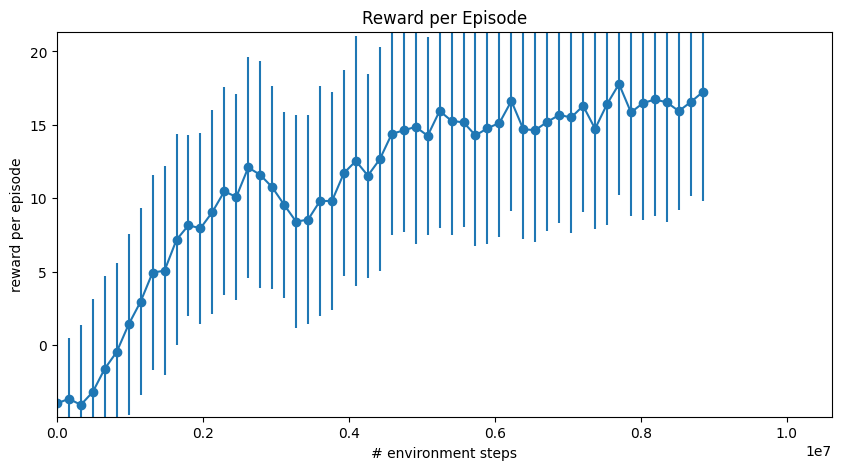

time to jit: 0:00:31.799535
time to train: 0:05:59.095541


In [14]:

train_fn = functools.partial(
      train, num_timesteps=500_000, num_evals=55,
      reward_scaling=1, episode_length=1000, normalize_observations=False,
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=1.0e-4,
      entropy_cost=1e-2, num_envs=2**13, batch_size=256,
      network_factory=make_networks_factory,
      auto_encode_factory=make_networks_factory_autoencode,
      seed=1,
      progress_fn=progress,
      policy_params_fn=display_vid)

env = envs.get_environment(ENV_NAME, random_length=RANDOM_LENGTH, scale_multiplier=0, random_nets_on=RANDOM_NETS_ON)
eval_env = envs.get_environment(ENV_NAME, random_length=RANDOM_LENGTH, scale_multiplier=0, random_nets_on=False)

make_inference_fn, params, auto_params, _= train_fn(environment=env, eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

## Saving

In [15]:
model_path = f'policies/{ENV_NAME}_00_{RANDOM_NETS_ON}_{RANDOM_LENGTH}'
auto_model_path = f'policies/auto_encoder/auto_encoder_00_{RANDOM_NETS_ON}_{RANDOM_LENGTH}'

In [16]:
model.save_params(model_path, params)
model.save_params(auto_model_path, auto_params)

# Loading

In [17]:
train_fn_q = functools.partial(
      train, num_timesteps=1, num_evals=1, episode_length=1, normalize_observations=False, num_envs=1, batch_size=1,
      network_factory=make_networks_factory, auto_encode_factory=make_networks_factory_autoencode)

e = envs.get_environment(ENV_NAME, random_length=RANDOM_LENGTH, scale_multiplier=0, random_nets_on=False)
make_inference_fn,_, _, _= train_fn_q(environment=e)

In [18]:
params = model.load_params(model_path)
auto_params = model.load_params(auto_model_path)

# Results

## Code

In [19]:
def gather_data(make_fn,params,auto_fact,auto_params,n_steps=500,start_flat=None,random_nets=False,scale=1,command=[1,0,-0.5],mask=jp.array([1]*12)):

  eval_env_vid = envs.get_environment(ENV_NAME, random_length=RANDOM_LENGTH, scale_multiplier=scale, random_nets_on=random_nets, mask=mask)
  jit_reset = jax.jit(eval_env_vid.reset)
  jit_step = jax.jit(eval_env_vid.step)

  inference_fn = make_fn(params)
  jit_inference_fn = jax.jit(inference_fn)

  # initialize the state
  rng = jax.random.PRNGKey(np.random.random_integers(0,1000000))
  state = jit_reset(rng)
  state.info['command'] = jp.array(command)
  if start_flat != None:
    p1,p2 = inverse_flatten_single(start_flat,12,31,RANDOM_LENGTH, RANDOM_LENGTH)
    state.info['p1']['params'] = p1
    state.info['p2']['params'] = p2
  rollout = [state.pipeline_state]

  if random_nets:
    flat = flatten_auto_encoder(state.info['p1']['params'],state.info['p2']['params'])
    pcount = flat.shape[-1]
    obs_encoder, obs_decoder = auto_fact(
      data_size_encode = state.obs.shape[-1],
      data_size_decode = state.obs.shape[-1])

    net_encoder, net_decoder = auto_fact(
    data_size_encode = pcount,
    data_size_decode =pcount)

    flat_encode = net_encoder.apply(auto_params[2], flat)

  embeds = []

  reward = 0

  for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    if random_nets:
      obs_embed = obs_encoder.apply(auto_params[0], state.obs)
      embeds.append(obs_embed)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    reward = state.info['rewards']

    rollout.append(state.pipeline_state)

    if state.done:
      break
  
  if random_nets:
    av_embedds = jp.average(jp.array(embeds),axis=0)
    flat_decoded = net_decoder.apply(auto_params[3], av_embedds)


  return flat, flat_encode, flat_decoded, av_embedds, embeds, reward, rollout, eval_env_vid

def renderGrid(amount,a=(-.5,.5),x=(-.5,.5),y=(-.5,.5)):
  isa = a[0] < a[1]
  isx = x[0] < x[1]
  isy = y[0] < y[1]

  for i in range(amount):
    for j in range(amount):
      if isa and isx:
        _a = (a[1]-a[0])*(i/(amount-1)) + a[0]
        _x = (x[1]-x[0])*(j/(amount-1)) + x[0]
        _y = y[0]
      elif isa and isy:
        _y = (y[1]-y[0])*(i/(amount-1)) + y[0]
        _a = (a[1]-a[0])*(j/(amount-1)) + a[0]
        _x = x[0]
      elif isx and isy:
        _y = (y[1]-y[0])*(i/(amount-1)) + y[0]
        _x = (x[1]-x[0])*(j/(amount-1)) + x[0]
        _a = a[0]
      else:
        raise ValueError('One of the axis must be a range')
      
      display_vid(f"a = {_a:.2f} x = {_x:.2f} y = {_y:.2f}",make_inference_fn,params,a=_a,x=_x,y=_y, save=False)

      clear_output(wait=True)
      grid_html = "<table>"
      for ii in range(0, amount**2, amount):
          grid_html += "<tr>"
          for jj in range(amount):
              if ii+jj >= len(html_vids):
                grid_html += f"<td></td>"
                break
              grid_html += f"<td>{html_vids[ii+jj]}</td>"
          grid_html += "</tr>"
      grid_html += "</table>"
      display(HTML(grid_html))

  return grid_html

In [20]:
def rend_vid(lable,rollout,eval_env_vid):
    render_every = 2
    media.show_video(eval_env_vid.render(rollout[::render_every], camera='tracking'),title=lable,fps=1.0 / eval_env_vid.dt / render_every)

## Vids

In [23]:
auto_params00 = model.load_params(f'policies/auto_encoder/auto_encoder_00_{RANDOM_NETS_ON}_{RANDOM_LENGTH}')
params00 = model.load_params(f'policies/{ENV_NAME}_00_{RANDOM_NETS_ON}_{RANDOM_LENGTH}')

auto_params50 = model.load_params(f'policies/auto_encoder/auto_encoder_50_{RANDOM_NETS_ON}_{RANDOM_LENGTH}')
params50 = model.load_params(f'policies/{ENV_NAME}_50_{RANDOM_NETS_ON}_{RANDOM_LENGTH}')

auto_params75 = model.load_params(f'policies/auto_encoder/auto_encoder_75_{RANDOM_NETS_ON}_{RANDOM_LENGTH}')
params75 = model.load_params(f'policies/{ENV_NAME}_50_{RANDOM_NETS_ON}_{RANDOM_LENGTH}')

In [24]:
flat, flat_encode, flat_decoded, av_embedds, embeds, reward, rollout, eval_env_vid = gather_data(make_inference_fn,
                    params00,
                    make_networks_factory_autoencode,
                    auto_params00,
                    n_steps=500,
                    random_nets=True,
                    scale=0,
                    command=[1,0,-0.5])

/tmp/ipykernel_1020/995965517.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1000000 + 1) instead
  rng = jax.random.PRNGKey(np.random.random_integers(0,1000000))


In [26]:
rend_vid('',rollout,eval_env_vid)

In [22]:
all_data = {}

all_data['00'] = {}
all_data['00']['p'] = params00
all_data['00']['a'] = auto_params00
all_data['50']= {}
all_data['50']['p'] = params50
all_data['50']['a'] = auto_params50
all_data['75'] = {}
all_data['75']['p'] = params75
all_data['75']['a'] = auto_params75

#flat, flat_encode, flat_decoded, av_embedds, embeds, rollout, env
# labs1 = ['test:.00','test:.25','test:.50','test:.75','test:1']
# s_vals = [0,.25,.5,.75,1]

# n_steps = 500
# for k in all_data.keys():
#     print(k)
#     for i in range(len(labs)):
#         lab = labs[i]
#         s_val = s_vals[i]
#         params = all_data[k]['p']
#         auto_params = all_data[k]['a']
#         all_data[k][lab] = []
#         for j in range(1):
#             all_data[k][lab].append(gather_data(make_inference_fn,
#                                                 params,
#                                                 make_networks_factory_autoencode,
#                                                 auto_params,
#                                                 n_steps=n_steps,
#                                                 random_nets=True,
#                                                 scale=s_val,
#                                                 command=[1,0,-0.5]))
            
labs = ['mask1','mask2','mask3','mask4','mask','other_mask']
s_vals = [jp.array([0,0,0,1,1,1,1,1,1,1,1,1]),jp.array([1,1,1,0,0,0,1,1,1,1,1,1]),jp.array([1,1,1,1,1,1,0,0,0,1,1,1]),jp.array([1,1,1,1,1,1,1,1,1,0,0,0]),jp.array([1,1,1,1,1,1,1,1,1,1,1,1]),jp.array([1,0,1,0,1,0,1,0,1,0,1,0])]

n_steps = 500
for k in all_data.keys():
    print(k)
    for i in range(len(labs)):
        lab = labs[i]
        s_val = s_vals[i]
        params = all_data[k]['p']
        auto_params = all_data[k]['a']
        all_data[k][lab] = []
        for j in range(1):
            all_data[k][lab].append(gather_data(make_inference_fn,
                                                params,
                                                make_networks_factory_autoencode,
                                                auto_params,
                                                n_steps=n_steps,
                                                random_nets=True,
                                                scale=0,
                                                command=[1,0,-0.5],
                                                mask=s_val))


00


/tmp/ipykernel_1020/995965517.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1000000 + 1) instead
  rng = jax.random.PRNGKey(np.random.random_integers(0,1000000))


KeyboardInterrupt: 

In [ ]:
import pickle

def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def sum_rewards(reward_dict):
    return sum([v for k,v in reward_dict.items()])

def create_emmbed_data(all_data):
    embed_data = []
    for k in all_data.keys():
        for i in range(len(labs)):
            lab = labs[i]
            curr = all_data[k][lab]
            for j in range(len(curr)):
                em = all_data[k][lab][j][4]
                for m in em:
                    embed_data.append((m,lab,k))

    return embed_data

def create_flat_data(all_data):
    flat_data = []
    for k in all_data.keys():
        for i in range(len(labs)):
            lab = labs[i]
            curr = all_data[k][lab]
            for j in range(len(curr)):
                flat_data.append((cosine_similarity(all_data[k][lab][j][0],all_data[k][lab][j][2]),cosine_similarity(all_data[k][lab][j][1],all_data[k][lab][j][3]),lab,k))

    return flat_data

def create_super_flat_data(all_data):
    flat_data = []
    for k in all_data.keys():
        for i in range(len(labs)):
            lab = labs[i]
            curr = all_data[k][lab]
            for j in range(len(curr)):
                flat_data.append((all_data[k][lab][j][0],all_data[k][lab][j][2],lab,k))

    return flat_data


def create_reward_data(all_data):
    reward_data = []
    for k in all_data.keys():
        for i in range(len(labs)):
            lab = labs[i]
            curr = all_data[k][lab]
            for j in range(len(curr)):
                reward_data.append((sum_rewards(all_data[k][lab][j][5]),lab,k))

    return reward_data
            
embed_data = create_emmbed_data(all_data)

with open('data/embed_data.pkl', 'wb') as f:
    pickle.dump(embed_data, f)

flat_data = create_flat_data(all_data)

with open('data/flat_data.pkl', 'wb') as f:
    pickle.dump(flat_data, f)

super_flat_data = create_super_flat_data(all_data)

with open('data/super_flat_data.pkl', 'wb') as f:
    pickle.dump(super_flat_data, f)


reward_data = create_reward_data(all_data)

with open('data/reward_data.pkl', 'wb') as f:
    pickle.dump(reward_data, f)

# Load Data

In [ ]:
import pickle
try:
    x = embed_data == None
except NameError:
    with open('data/embed_data.pkl', 'rb') as f:
        embed_data = pickle.load(f)

try:
    x = flat_data == None
except NameError:
    with open('data/flat_data.pkl', 'rb') as f:
        flat_data = pickle.load(f)

try:
    x = super_flat_data == None
except NameError:
    with open('data/super_flat_data.pkl', 'rb') as f:
        super_flat_data = pickle.load(f)

try:
    x = reward_data == None
except NameError:
    with open('data/reward_data.pkl', 'rb') as f:
        reward_data = pickle.load(f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

def plot_reduced_data(X, labels,title="dataset", methods=['PCA', 't-SNE', 'LDA']):
    # Encode labels to integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Set up the plot
    fig, axes = plt.subplots(1, len(methods), figsize=(5 * len(methods), 5))
    if len(methods) == 1:
        axes = [axes]

    # Apply each method and plot
    for ax, method in zip(axes, methods):
        if method == 'PCA':
            reducer = PCA(n_components=2)
        elif method == 't-SNE':
            reducer = TSNE(n_components=2, random_state=0)
        elif method == 'LDA':
            # LDA requires minimum number of labels for dimensions
            reducer = LinearDiscriminantAnalysis(n_components=2)
        else:
            raise ValueError(f"Unsupported reduction method: {method}")

        # Fit and transform the data
        if method == 'LDA':
            X_reduced = reducer.fit_transform(X, labels_encoded)
        else:
            X_reduced = reducer.fit_transform(X)

        # Plot
        scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_encoded, cmap='viridis', alpha=0.6)
        ax.set_title(f'{method} of {title}')
        ax.grid(True)

    cbar = fig.colorbar(scatter, ax=axes, orientation='vertical')
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)
    plt.show()



In [ ]:
def create_data_and_lables(data, data_select=[0], lable_select=[True,True], neg_filter="", pos_filter=""):
    data_out = []
    lables_out = []
    for i in range(len(data)):
        l = len(data[i])
        dat = []
        for j in data_select:
            if j < l-2:
                dat.append(data[i][j])
        
        lab = ""
        if lable_select[0]:
            lab += data[i][-2]
        if lable_select[1]:
            lab += " trained:." + data[i][-1]
        if (neg_filter == "" or not neg_filter in lab) and (pos_filter == "" or pos_filter in lab):
            data_out.append(dat)
            lables_out.append(lab)
    return data_out, lables_out 

import numpy as np
import matplotlib.pyplot as plt

def plot_average_values_by_sublabel_adjacent(data, labels, delimiter=' '):
    # Ensure data is a numpy array for easier manipulation
    data = np.array(data)
    labels = np.array(labels)

    # Split labels into main groups and sublabels and create a composite label
    composite_labels = [label.strip().lower() for label in labels]
    main_groups = [label.split(delimiter)[0] if delimiter in label else 'no_delimiter' for label in labels]
    main_groups = [label.split(delimiter)[1] if delimiter in label else label for label in labels]

    # Prepare color mapping for main groups
    unique_main_groups = np.unique(main_groups)
    color_map = {group: plt.cm.tab20(i / len(unique_main_groups)) for i, group in enumerate(unique_main_groups)}

    # Group data by composite labels and compute averages
    unique_composite_labels = np.unique(composite_labels)
    composite_label_means = []
    composite_label_colors = []

    print("Composite Labels:", unique_composite_labels)

    for label in unique_composite_labels:
        indices = np.array([i for i, comp_label in enumerate(composite_labels) if comp_label == label])
        label_data = data[indices, :]
        mean_values = np.mean(label_data, axis=0)
        composite_label_means.append(np.mean(mean_values))  # Average over all features
        # Assign color based on the main group part of the composite label
        main_group_for_color = main_groups[indices[0]]
        composite_label_colors.append(color_map[main_group_for_color])

    # Plotting the bar chart
    plt.figure(figsize=(15, 6))
    bars = plt.bar(unique_composite_labels, composite_label_means, color=composite_label_colors)
    plt.xlabel('Composite Labels')
    plt.ylabel('Average Reward')
    plt.title('Average Reward by Train Scale and Test Scale')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Create a legend for the main groups
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[group], label=group) for group in unique_main_groups]
    plt.legend(handles=legend_elements, title="Main Groups")

    plt.show()


In [ ]:
for l in [' trained:.00',' trained:.50',' trained:.75']:
    data1, label1 = create_data_and_lables(embed_data, data_select=[0], lable_select=[True,True], pos_filter=l)
    plot_reduced_data(np.array(data1).squeeze(axis=1), label1,title=f"{l}", methods=['PCA', 't-SNE', 'LDA'])

In [ ]:

data1, label1 = create_data_and_lables(reward_data, data_select=[0], lable_select=[True,True])
plot_average_values_by_sublabel_adjacent(np.array(data1), label1)